In [66]:
# Importing the different packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import minimize #optimization
np.random.seed(69)

In [44]:
# Setting up the different parameters:

dt = 0.00001 #The 
D = 1000 # Diffusion coefficient 
L = 10 # The size of the beam spot, half of it to be exact
N = 20 # The starting number of particles
tt = 0.1 # The total time of the simulation
maxI = 5000

In [45]:
# First randomly generate the locations of the different particles, then calculate the intensity by summing them all up 
# and multiplying by the maximum intensity of the species of particle
# Then generate the first increment of time based on that summed intensity
x = 2*L*np.random.random(size=(N,))
x = np.mod(x,2*L)-L 
intensity = norm.pdf(x,loc=0)
intensity = np.sum(intensity,axis=0)
current_int = intensity*maxI
delta_t = np.random.exponential(1/current_int)

(array([228., 138.,  41.,  23.,  17.,  13.,   8.,   6.,   3.,   1.,   1.,
          1.,   1.,   1.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([2.75253089e-08, 1.09950192e-04, 2.19872858e-04, 3.29795525e-04,
        4.39718192e-04, 5.49640858e-04, 6.59563525e-04, 7.69486191e-04,
        8.79408858e-04, 9.89331525e-04, 1.09925419e-03, 1.20917686e-03,
        1.31909952e-03, 1.42902219e-03, 1.53894486e-03, 1.64886752e-03,
        1.75879019e-03, 1.86871286e-03, 1.97863552e-03, 2.08855819e-03,
        2.19848086e-03, 2.30840352e-03, 2.41832619e-03, 2.52824886e-03,
        2.63817152e-03, 2.74809419e-03, 2.85801686e-03, 2.96793952e-03,
        3.07786219e-03, 3.18778486e-03, 3.29770752e-03]),
 <a list of 30 Patch objects>)

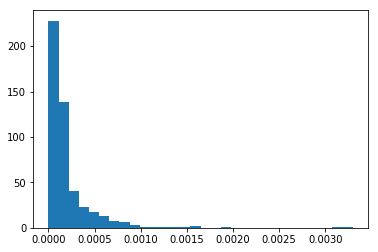

In [46]:
# Starting at the beginning, the lists are generated to store the different values
# The in each part of the loop, the particles are kicked randomly and the intesnity is found
# by summing every particle's intensity. The next increment of time is found based on the current
# summed intensity. This is done until the total time is reached

# Due to how long each simulation took, we shortened the total time while increasing the intensity and the 
# diffusion coefficient to get a more representative sample of a FCS experiment in a shorter time period.

time = 0
intensitylist = [current_int]
timelist = []
delta_t_list=[delta_t]
while time < tt:
    time = time+delta_t
    timelist.append(time)
    increment = np.random.normal(loc=0.0,scale=np.sqrt(2*D*delta_t),size=(N,1))
    x = np.column_stack((x,increment))
    paths = np.mod(np.cumsum(x,axis=1),2*L)-L
    intensity = norm.pdf(paths[:,-1],loc=0)*maxI
    currentintensity = np.sum(intensity,axis=0)
    intensitylist.append(currentintensity)
    delta_t = np.random.exponential(1/currentintensity)
    delta_t_list.append(delta_t)

#Plots the resulting spread of the different delta t.    
plt.hist(delta_t_list,bins=30)

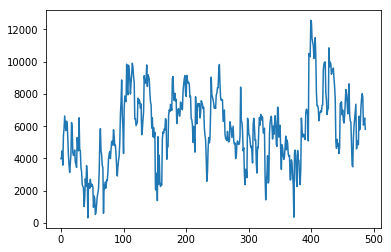

In [47]:
# Plots the summed intesnities over that total time period to show that the data can represent a typical FCS experiement
plt.plot(intensitylist)

In [48]:
t = np.array(delta_t_list) # time array
t.sort(axis=0)
N = len(t)
N

487

In [49]:
# Likelihood function
def p_dt_integrant(pos,flux):
    f = np.exp(-flux*pos)/np.sqrt(-np.log(pos))
    return f

In [51]:
# Taking the log sum of the liklihood function in order to minimize it later
# Took the negative of it in order to turn the maximum into a minimum
# This way we can use pre-existing optimization functions to find the maximum turned minimum
def objective(II):
    flux = II*t
    sol = np.array([quad(p_dt_integrant,0,1,args=(f))[0] for f in flux])
    obj = -1 * (N*np.log(II)+np.sum(np.log(sol)))
    return obj

In [53]:
# Afterwards we minimize the objective function to find the maximum and print it out
res = minimize(objective,10,options={'disp':True})
I0_opt = res.x[0]
print('I0 =',str(I0_opt),'minimizes the likelihood')

Optimization terminated successfully.
         Current function value: -4333.913762
         Iterations: 21
         Function evaluations: 69
         Gradient evaluations: 23
I0 = 22859.51209201215 minimizes the likelihood


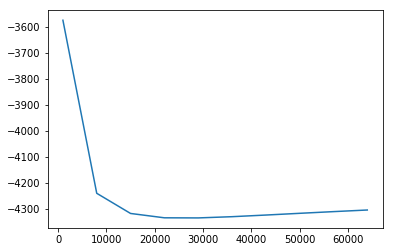

In [59]:
# We then print out the shape of that objective function by computing in a loop
# the values at different points in the function
I0 = 1000
tt = []
s = []
for i in range(10):
    tt.append(I0)
    flux = I0*t
    f = np.array([quad(p_dt_integrant,0,1,args=(f))[0] for f in flux])
    likelihood = -N*np.log(I0)-np.sum(np.log(f))
    s.append(likelihood)
    I0 = I0+7000
plt.plot(tt,s)